In [ ]:
import pandas as pd
import pickle
import os
import numpy as np
# data = pickle.load(open('../data/leftppgecg.p','rb'))
directory = '../data_users/ecg_ppg/'
dfs = []
for f in os.listdir(directory)[:50]:
    if f[-1]!='p':
        continue
    a = pickle.load(open(directory+f,'rb'))
    print(a.shape,end=',')
    dfs.append(a)
print()
data1 = pd.concat(dfs)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features

from copy import deepcopy
data_all = deepcopy(data1)

data_all['red_rr'] = data_all['ppg_rr'].apply(lambda x:x[0])
data_all['ir_rr'] = data_all['ppg_rr'].apply(lambda x:x[1])
data_all['green_rr'] = data_all['ppg_rr'].apply(lambda x:x[2])
data_all['red_qual'] = data_all['likelihood'].apply(lambda x:x[0])
data_all['ir_qual'] = data_all['likelihood'].apply(lambda x:x[1])
data_all['green_qual'] = data_all['likelihood'].apply(lambda x:x[2])
data_all['index'] = data_all['likelihood'].apply(lambda x:np.argmax(np.array(x)))
values = data_all[['ppg_rr','index']].values
values = [a[b] for a,b in values]
data_all['ppg_rr_best'] = values
data_all['likelihood_best'] = data_all['likelihood'].apply(lambda x:max(x))

In [ ]:
import pickle
pickle.dump(data_all,open('../data_users/merged_data.p','wb'),protocol=4)

In [1]:
import pandas as pd
import pickle
import os
import numpy as np
data_all = pickle.load(open('../data_users/merged_data.p','rb'))

In [2]:
data_all.shape

(29536929, 18)

In [3]:
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features

from copy import deepcopy
def get_data1(a):
    features = []
    ecg_rr = a[:,-1]
    if len(ecg_rr[np.isnan(ecg_rr)])>20:
        return [],[],[],[],[],[]
    ecg_rr[np.isnan(ecg_rr)] = np.nanmean(ecg_rr)
    m = np.mean(ecg_rr[ecg_rr>0])
    s = np.mean(ecg_rr[ecg_rr>0])
    if len(ecg_rr)<60:
        return [],[],[],[],[],[]
    y = []
    X = []
    ecg = []
    means = []
    stds = []
    quals = []
    for i in [-2]:
        ppg_rr = a[:,i]
        ppg_qual = a[:,i-4]
        index1 = ~np.isnan(ppg_rr)
        if len(ppg_rr[index1])<30:
            continue
        index = np.isnan(ppg_rr)
        ppg_qual[index] = -1
        index = np.isnan(ppg_qual)
        ppg_qual[index] = -1
        tmp = a[:,np.array([-2,-3,-4,-5,-6,-7,-8,-9,1])].reshape(60,9)
        for k in range(4):
            tmp[np.isnan(tmp[:,k]),k] = np.nanmean(tmp[:,k])
            tmp[tmp[:,k]==0,k] = np.mean(tmp[tmp[:,k]>0,k])
        tmp[np.isnan(tmp)] = 0
        y.append(tmp[:,0].reshape(1,60,1))
        X.append(tmp.reshape(1,60,9))
        means.append(m)
        stds.append(s)
        ecg.append(ecg_rr.reshape(1,60,1))
        quals.append(ppg_qual.reshape(1,60,1))
    return X,y,ecg,means,stds,quals

unique_users = data_all['user'].unique()

def get_data(name,df):
    df = df[['time','activity','red_qual','ir_qual','green_qual','likelihood_best',
             'red_rr','ir_rr','green_rr','ppg_rr_best','ecg_rr']].values
    return df.reshape(-1,60,11)
def get_all_data(data_user):
    data_user.set_index('timestamp',inplace=True)
    convert_dict = {'ecg_rr': float}
    data_user = data_user.astype(convert_dict) 
    data_resampled = data_user.resample('1S').mean()
    if 'ecg_rr' not in np.array(data_resampled.columns.values):
        return []
    df_col = [get_data(group_name, df_group) for group_name, df_group
                                           in data_resampled.groupby(pd.Grouper(freq='60S')) if df_group.shape[0]==60]
    df_user = np.concatenate(df_col)
    df_col = [get_data1(a) for a in df_user if len(a[~np.isnan(a[:,-1]),-1])>20]
    return df_col
# for user in unique_users:
#     data_user = data_all[data_all.user.isin([user])]
all_X = Parallel(n_jobs=20,verbose=3)(delayed(get_all_data)(data_all[data_all.user.isin([user])]) for user in unique_users)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  28 out of  50 | elapsed:  3.6min remaining:  2.8min
[Parallel(n_jobs=20)]: Done  45 out of  50 | elapsed:  5.4min remaining:   36.1s
[Parallel(n_jobs=20)]: Done  50 out of  50 | elapsed:  6.2min finished


In [4]:
X,y,ecg,means,stds,quals = [],[],[],[],[],[]
for i,b in enumerate(all_X):
    if len(b)==0:
        continue
    for a in b:
        X.extend(a[0])
        y.extend(a[1])
        ecg.extend(a[2])
        means.extend(a[3])
        stds.extend(a[4])
        quals.extend(a[5])

In [5]:
import pickle
pickle.dump([X,y,ecg,means,stds,quals],open('../data_users/processed_data.p','wb'),protocol=4)

In [38]:
import pandas as pd
import pickle
import os
import numpy as np
X,y,ecg,means,stds,quals = pickle.load(open('../data_users/processed_data.p','rb'))

In [39]:
X,y,ecg,means,stds,quals = np.concatenate(X),np.concatenate(y).reshape(-1,60),np.concatenate(ecg).reshape(-1,60),\
np.array(means).reshape(-1,1),np.array(stds).reshape(-1,1),np.concatenate(quals)

In [40]:
from keras.layers import Input, LSTM, RepeatVector,Bidirectional,Multiply,multiply,Permute
from keras.layers import TimeDistributed,Dense,Flatten,Reshape,Lambda,Activation,GRU
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import keras.backend as K
from keras import metrics,losses
import tensorflow as tf
import tensorflow_probability as tfp
X_train, X_test, y_train, y_test,ecg_train, \
ecg_test,means_train,means_test,stds_train,stds_test, \
quals_train,quals_test= train_test_split(
    X[:,:,np.array([1,2,3,5,6,7,8])], y,ecg,means,stds,quals, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val,means_train,means_val,stds_train,stds_val = train_test_split(
    X_train, y_train,means_train,stds_train, test_size=0.2, random_state=42)
print(X_train.shape,y_test.shape,y_val.shape,means_val.shape,stds_val.shape)

(32330, 60, 7) (19905, 60) (8083, 60) (8083, 1) (8083, 1)


In [43]:
def output_of_lambda(input_shape):
    return (input_shape[0], 1)

def mean(x):
    return K.mean(x,axis=1,keepdims=True)

def output_of_lambda1(input_shape):
    return (input_shape[0], 1)

def mean1(x):
    return K.mean(x,axis=1,keepdims=True)

timesteps = 60
input_dim = 7
latent_dim = 20
output_dim = 1
n = 1
inputs = Input(shape=(timesteps, input_dim))
# inputs2 = Reshape((1,1))(inputs1)
encoded = Bidirectional(GRU(60,return_sequences=True,activation='linear',go_backwards=True))(inputs)
# encoded = LSTM(output_dim,return_sequences=True,activation='sigmoid')(encoded)
att = Dense(1,activation='relu')(encoded)

att = Flatten()(att)
att = Activation(activation="softmax")(att)
att = RepeatVector(120)(att)
att = Permute((2,1))(att)
mer = multiply([att, encoded])

# encoded = TimeDistributed(Dense(,activation='relu'))(mer)
encoded = Flatten()(mer)
encoded = Dense(30,activation='relu',name='sequence1')(encoded)
encoded = Dense(60,activation='relu',name='sequence')(encoded)
# encoded = Reshape((60),name='sequence')(encoded)
# encoded_std = K.std(encoded,axis=1)
decoded = Lambda(mean, output_shape=output_of_lambda,name='mean')(encoded)
decoded1 = Lambda(mean1, output_shape=output_of_lambda1,name='std')(encoded)
# decoded = LSTM(output_dim*60, return_sequences=True)(decoded)
# decoded = LSTM(output_dim*3, return_sequences=True)(decoded)
# decoded = LSTM(output_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs=[inputs], outputs=[encoded,decoded,decoded1])
# encoder = Model(inputs, encoded)
losses = {
    "std":"logcosh",
    "mean": "logcosh",
    "sequence": "logcosh"
}
lossWeights = {"mean": 0, "sequence": 1,"std":0}
# initialize the optimizer and compile the model

sequence_autoencoder.compile(optimizer='adam',loss=losses, loss_weights=lossWeights)

sequence_autoencoder.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 60, 7)        0                                            
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 60, 120)      24480       input_4[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 60, 1)        121         bidirectional_4[0][0]            
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 60)           0           dense_4[0][0]                    
____________________________________________________________________________________________

In [44]:
filepath = '../models/base_LSTM.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=30)
callbacks_list = [es,checkpoint]
history = sequence_autoencoder.fit(X_train, [y_train,means_train,stds_train],
                epochs=300,
                batch_size=500,
                shuffle=True,
                validation_data=(X_val,[y_val,means_val,stds_val]),callbacks=callbacks_list)

Train on 32330 samples, validate on 8083 samples
Epoch 1/300
32330/32330 [==============================] - 11s 330us/step - loss: 484.6503 - sequence_loss: 483.3098 - mean_loss: 392.7352 - std_loss: 392.7352 - val_loss: 227.2839 - val_sequence_loss: 227.3480 - val_mean_loss: 118.3731 - val_std_loss: 118.3731

Epoch 00001: val_loss improved from inf to 227.28393, saving model to ../models/base_LSTM.hdf5
Epoch 2/300
32330/32330 [==============================] - 10s 308us/step - loss: 215.1182 - sequence_loss: 215.1219 - mean_loss: 111.7055 - std_loss: 111.7055 - val_loss: 209.5734 - val_sequence_loss: 209.5641 - val_mean_loss: 105.9396 - val_std_loss: 105.9396

Epoch 00002: val_loss improved from 227.28393 to 209.57340, saving model to ../models/base_LSTM.hdf5
Epoch 3/300
32330/32330 [==============================] - 10s 307us/step - loss: 208.0884 - sequence_loss: 208.0927 - mean_loss: 105.5182 - std_loss: 105.5182 - val_loss: 205.8693 - val_sequence_loss: 205.7545 - val_mean_loss: 1

32330/32330 [==============================] - 11s 347us/step - loss: 196.7868 - sequence_loss: 196.7834 - mean_loss: 93.8577 - std_loss: 93.8577 - val_loss: 196.8618 - val_sequence_loss: 196.8150 - val_mean_loss: 91.1165 - val_std_loss: 91.1165

Epoch 00024: val_loss improved from 196.92203 to 196.86178, saving model to ../models/base_LSTM.hdf5
Epoch 25/300
32330/32330 [==============================] - 11s 336us/step - loss: 196.2412 - sequence_loss: 196.2387 - mean_loss: 93.2302 - std_loss: 93.2302 - val_loss: 196.6980 - val_sequence_loss: 196.6870 - val_mean_loss: 91.0269 - val_std_loss: 91.0269

Epoch 00025: val_loss improved from 196.86178 to 196.69799, saving model to ../models/base_LSTM.hdf5
Epoch 26/300
32330/32330 [==============================] - 11s 348us/step - loss: 196.5360 - sequence_loss: 196.5510 - mean_loss: 93.4091 - std_loss: 93.4091 - val_loss: 196.4239 - val_sequence_loss: 196.4335 - val_mean_loss: 92.5681 - val_std_loss: 92.5681

Epoch 00026: val_loss improved 

32330/32330 [==============================] - 7s 208us/step - loss: 191.4433 - sequence_loss: 191.4427 - mean_loss: 88.9590 - std_loss: 88.9590 - val_loss: 192.6500 - val_sequence_loss: 192.5802 - val_mean_loss: 90.8723 - val_std_loss: 90.8723

Epoch 00047: val_loss did not improve from 192.40042
Epoch 48/300
32330/32330 [==============================] - 7s 218us/step - loss: 191.5325 - sequence_loss: 191.5360 - mean_loss: 89.3407 - std_loss: 89.3407 - val_loss: 192.3460 - val_sequence_loss: 192.3074 - val_mean_loss: 89.7471 - val_std_loss: 89.7471

Epoch 00048: val_loss improved from 192.40042 to 192.34599, saving model to ../models/base_LSTM.hdf5
Epoch 49/300
32330/32330 [==============================] - 7s 209us/step - loss: 191.1883 - sequence_loss: 191.1988 - mean_loss: 88.9623 - std_loss: 88.9623 - val_loss: 191.9015 - val_sequence_loss: 191.8982 - val_mean_loss: 87.7371 - val_std_loss: 87.7371

Epoch 00049: val_loss improved from 192.34599 to 191.90153, saving model to ../mod

32330/32330 [==============================] - 7s 209us/step - loss: 149.2971 - sequence_loss: 149.2998 - mean_loss: 85.8195 - std_loss: 85.8195 - val_loss: 147.3168 - val_sequence_loss: 147.3700 - val_mean_loss: 84.2592 - val_std_loss: 84.2592

Epoch 00071: val_loss improved from 149.05319 to 147.31681, saving model to ../models/base_LSTM.hdf5
Epoch 72/300
32330/32330 [==============================] - 7s 209us/step - loss: 148.5665 - sequence_loss: 148.5786 - mean_loss: 85.8452 - std_loss: 85.8452 - val_loss: 149.7601 - val_sequence_loss: 149.7929 - val_mean_loss: 85.0297 - val_std_loss: 85.0297

Epoch 00072: val_loss did not improve from 147.31681
Epoch 73/300
32330/32330 [==============================] - 7s 219us/step - loss: 150.8124 - sequence_loss: 150.8323 - mean_loss: 86.0811 - std_loss: 86.0811 - val_loss: 150.5640 - val_sequence_loss: 150.5549 - val_mean_loss: 85.4764 - val_std_loss: 85.4764

Epoch 00073: val_loss did not improve from 147.31681
Epoch 74/300
32330/32330 [===


Epoch 00095: val_loss did not improve from 139.21510
Epoch 96/300
32330/32330 [==============================] - 11s 325us/step - loss: 140.1309 - sequence_loss: 140.1365 - mean_loss: 85.6483 - std_loss: 85.6483 - val_loss: 138.6648 - val_sequence_loss: 138.7231 - val_mean_loss: 84.3427 - val_std_loss: 84.3427

Epoch 00096: val_loss improved from 139.21510 to 138.66483, saving model to ../models/base_LSTM.hdf5
Epoch 97/300
32330/32330 [==============================] - 10s 318us/step - loss: 138.9115 - sequence_loss: 138.9015 - mean_loss: 85.5607 - std_loss: 85.5607 - val_loss: 140.4539 - val_sequence_loss: 140.5379 - val_mean_loss: 85.4227 - val_std_loss: 85.4227

Epoch 00097: val_loss did not improve from 138.66483
Epoch 98/300
32330/32330 [==============================] - 10s 322us/step - loss: 139.3656 - sequence_loss: 139.3669 - mean_loss: 85.6784 - std_loss: 85.6784 - val_loss: 138.8078 - val_sequence_loss: 138.8623 - val_mean_loss: 83.8600 - val_std_loss: 83.8600

Epoch 00098:

32330/32330 [==============================] - 11s 350us/step - loss: 135.2748 - sequence_loss: 135.2845 - mean_loss: 84.9754 - std_loss: 84.9754 - val_loss: 135.6200 - val_sequence_loss: 135.6916 - val_mean_loss: 83.3362 - val_std_loss: 83.3362

Epoch 00120: val_loss improved from 135.84869 to 135.62004, saving model to ../models/base_LSTM.hdf5
Epoch 121/300
32330/32330 [==============================] - 12s 356us/step - loss: 136.8857 - sequence_loss: 136.8850 - mean_loss: 85.1194 - std_loss: 85.1194 - val_loss: 135.4863 - val_sequence_loss: 135.5725 - val_mean_loss: 85.7629 - val_std_loss: 85.7629

Epoch 00121: val_loss improved from 135.62004 to 135.48628, saving model to ../models/base_LSTM.hdf5
Epoch 122/300
32330/32330 [==============================] - 11s 348us/step - loss: 135.7192 - sequence_loss: 135.7411 - mean_loss: 85.2849 - std_loss: 85.2849 - val_loss: 136.7351 - val_sequence_loss: 136.8371 - val_mean_loss: 84.9329 - val_std_loss: 84.9329

Epoch 00122: val_loss did not

32330/32330 [==============================] - 11s 331us/step - loss: 133.3472 - sequence_loss: 133.3207 - mean_loss: 84.9714 - std_loss: 84.9714 - val_loss: 134.0396 - val_sequence_loss: 134.1110 - val_mean_loss: 85.6342 - val_std_loss: 85.6342

Epoch 00145: val_loss did not improve from 133.48784
Epoch 146/300
32330/32330 [==============================] - 11s 347us/step - loss: 135.0776 - sequence_loss: 135.0605 - mean_loss: 84.9500 - std_loss: 84.9500 - val_loss: 134.3342 - val_sequence_loss: 134.4235 - val_mean_loss: 84.0028 - val_std_loss: 84.0028

Epoch 00146: val_loss did not improve from 133.48784
Epoch 147/300
32330/32330 [==============================] - 12s 360us/step - loss: 134.5022 - sequence_loss: 134.4817 - mean_loss: 84.8466 - std_loss: 84.8466 - val_loss: 138.8168 - val_sequence_loss: 138.9462 - val_mean_loss: 84.6480 - val_std_loss: 84.6480

Epoch 00147: val_loss did not improve from 133.48784
Epoch 148/300
32330/32330 [==============================] - 11s 347us/s

KeyboardInterrupt: 

In [45]:
from keras.models import load_model
import tensorflow_probability as tfp
sequence_autoencoder = load_model(filepath)

In [46]:
y_pred1 = sequence_autoencoder.predict(X_test)
y_pred = y_pred1[0]
mean_pred = y_pred1[1]
stds_pred = y_pred1[2]

In [47]:
y_pred1[0].shape,y_pred1[1].shape,y_pred1[2].shape

((19905, 60), (19905, 1), (19905, 1))

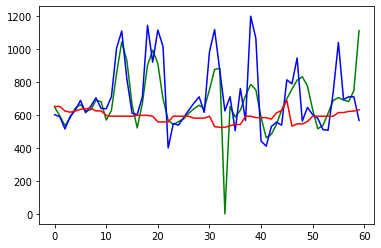

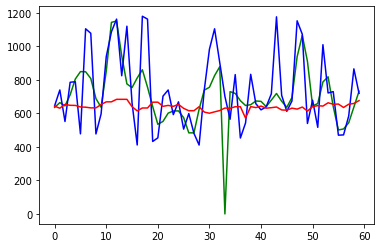

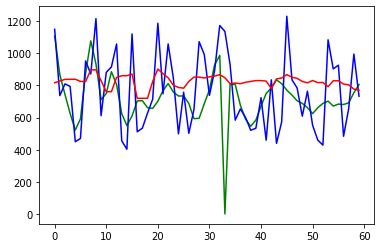

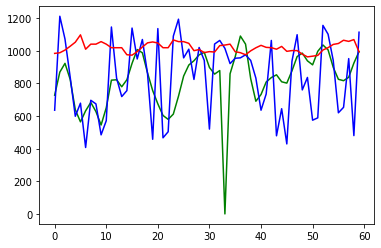

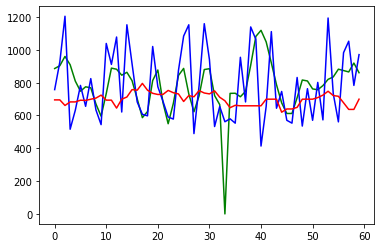

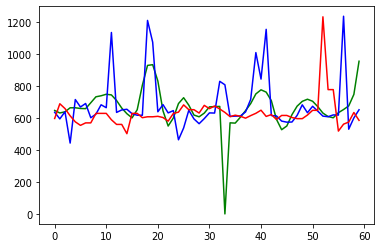

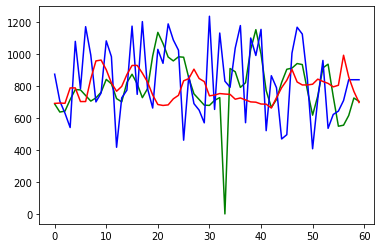

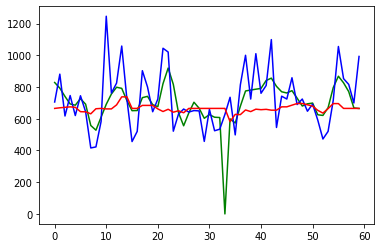

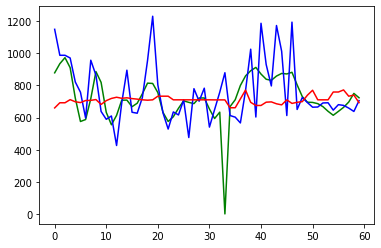

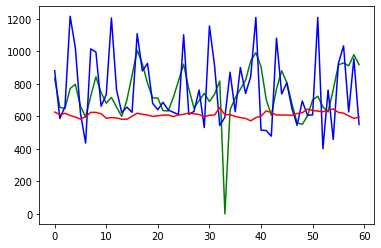

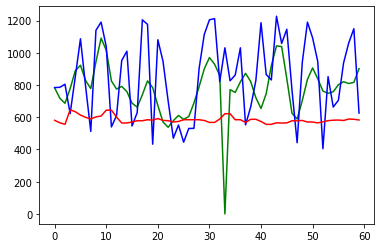

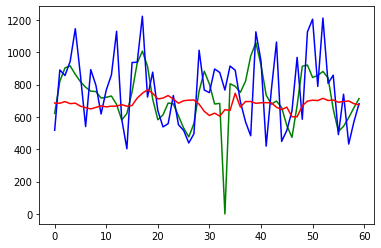

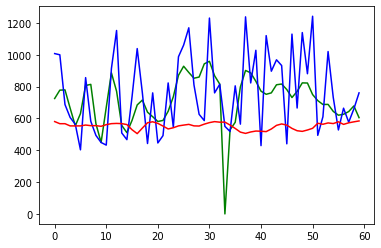

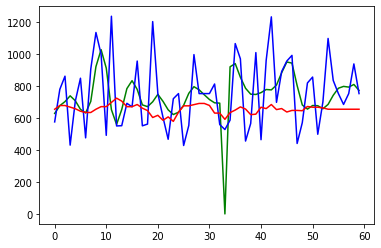

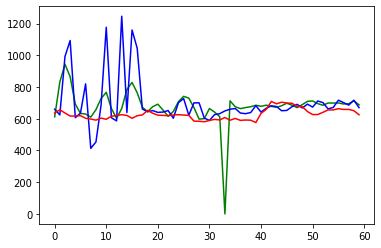

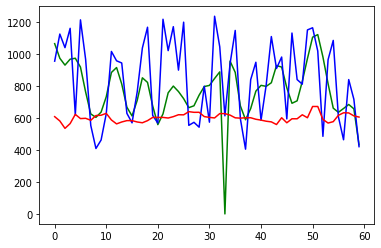

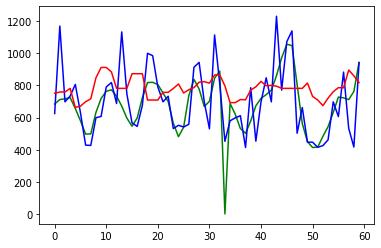

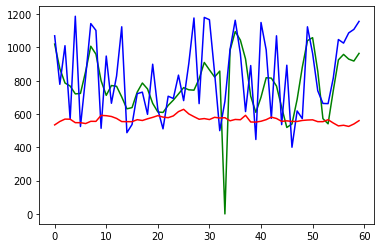

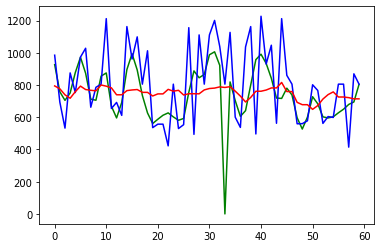

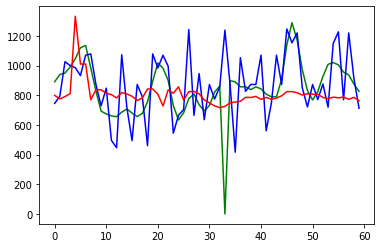

In [50]:
%matplotlib  inline
import matplotlib.pyplot as plt
# plt.plot(y[-10])
for i,a in enumerate(y_pred[:20]):
#     if np.sum(a)>0:
    plt.figure()
    plt.plot(a,'g')
#     plt.plot(X_test[i,:,:4],'r')
    plt.plot(y_test[i],'b')
    plt.plot(ecg_test[i],'r')
    plt.show()

In [51]:
X = np.zeros((len(quals_test.reshape(-1)),4))
X[:,0] = quals_test.reshape(-1)
X[:,1] = y_pred.reshape(-1)
X[:,2] = ecg_test.reshape(-1)
X[:,3] = y_test.reshape(-1)

In [52]:
X = X[X[:,0]>-1]
X = X[X[:,2]>0]
X = X[X[:,3]>0]
X = X[X[:,1]>0]

(array([431158., 160685.,  92237.,  74744.,  65979.,  59500.,  54150.,
         53333.,  56222., 123837.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

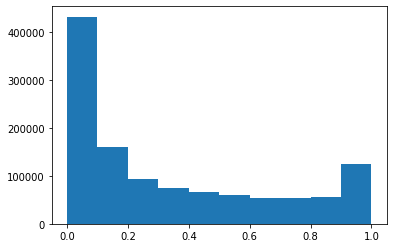

In [53]:
plt.hist(X[:,0])

(260474, 4) 0.0
(170684, 4) 0.05
(97140, 4) 0.1
(63545, 4) 0.15000000000000002
(49777, 4) 0.2
(41908, 4) 0.25
(38635, 4) 0.30000000000000004
(36109, 4) 0.35000000000000003
(33959, 4) 0.4
(32020, 4) 0.45
(30609, 4) 0.5
(28891, 4) 0.55
(27347, 4) 0.6000000000000001
(27182, 4) 0.65
(26588, 4) 0.7000000000000001
(27137, 4) 0.75
(28192, 4) 0.8
(28774, 4) 0.8500000000000001
(34575, 4) 0.9
(64470, 4) 0.9500000000000001
20 20


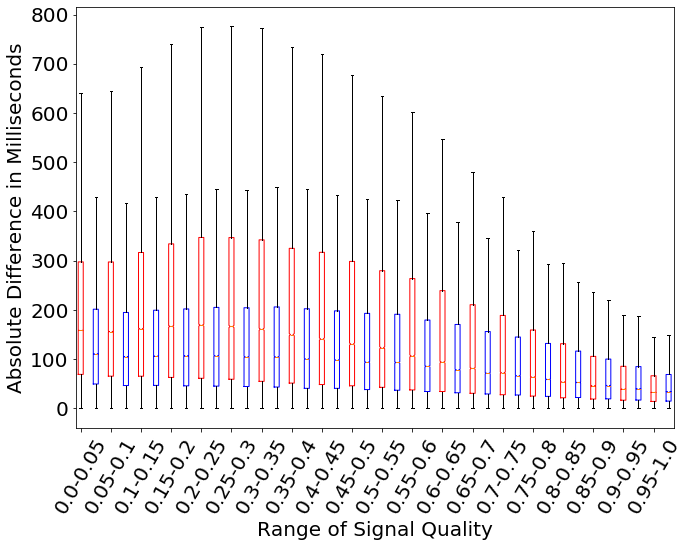

In [54]:
l_range = np.arange(0,1,.05)
x = []
y = []
y1 = []
for l in l_range:
    index = np.where((X[:,0]>=l)&(X[:,0]<l+.05))[0]
    temp = X[index]
    print(temp.shape,l)
    x.append(str(np.round(l*100)/100)+'-'+str(np.round((l+.05)*100)/100))
    y.append(list(np.abs(temp[:,2]-temp[:,3])))
    a = np.array(np.abs(temp[:,1]-temp[:,2]))
    y1.append(a[~np.isnan(a)])
print(len(y),len(y1))
#     print(np.mean(np.abs(temp[:,0]-temp[:,2])),np.std(np.abs(temp[:,0]-temp[:,2])),len(index))
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size':20})
c = plt.boxplot(y,showfliers=False,positions=np.array(range(0,3*len(y),3)),notch=True)
for box in c['boxes']:
    box.set(color='red', linewidth=1)
b = plt.boxplot(y1,showfliers=False,positions=np.array(range(0,3*len(y),3))+1.5,notch=True)
for box in b['boxes']:
    box.set(color='blue', linewidth=1)
#     box.set(facecolor = 'red' )
plt.xticks(np.array(range(0,3*len(y),3)),x,rotation=60)
plt.ylabel('Absolute Difference in Milliseconds')
plt.xlabel('Range of Signal Quality')
plt.tight_layout()
plt.show()   

In [55]:
from hrvanalysis import get_time_domain_features
x = []
y = []
z = []
q = []
s = 'range_nni'
for i in range(ecg_test.shape[0]):
    qual_min = quals_test[i].reshape(-1)
    qual_min = qual_min[qual_min>-1]
    ecg_min = ecg_test[i].reshape(-1)
    ecg_min = ecg_min[ecg_min>0]
    ecg_min= ecg_min[~np.isnan(ecg_min)]
    y_pred_min = y_pred[i].reshape(-1)
    y_pred_min = y_pred_min[~np.isnan(y_pred_min)]
    y_test_min = y_test[i].reshape(-1)
    y_test_min = y_test_min[y_test_min>0]
    y_test_min = y_test_min[~np.isnan(y_test_min)]
    if len(ecg_min)<40 or len(y_pred_min)<30 or len(y_test_min)<30:
        continue
    x.append(np.array(list(get_time_domain_features(y_pred_min).values())))
    y.append(np.array(list(get_time_domain_features(ecg_min).values())))
    z.append(np.array(list(get_time_domain_features(y_test_min).values())))
    q.append(np.mean(qual_min))

In [56]:
preds,ecgs,fpreds,q = np.array(x),np.array(y),np.array(z),np.array(q)

In [57]:
preds.shape,ecgs.shape,fpreds.shape,q.shape

((19905, 16), (19905, 16), (19905, 16), (19905,))

In [58]:
preds[:,-5]

array([0.24109748, 0.24200848, 0.21104395, ..., 0.18566127, 0.19847846,
       0.20498134])

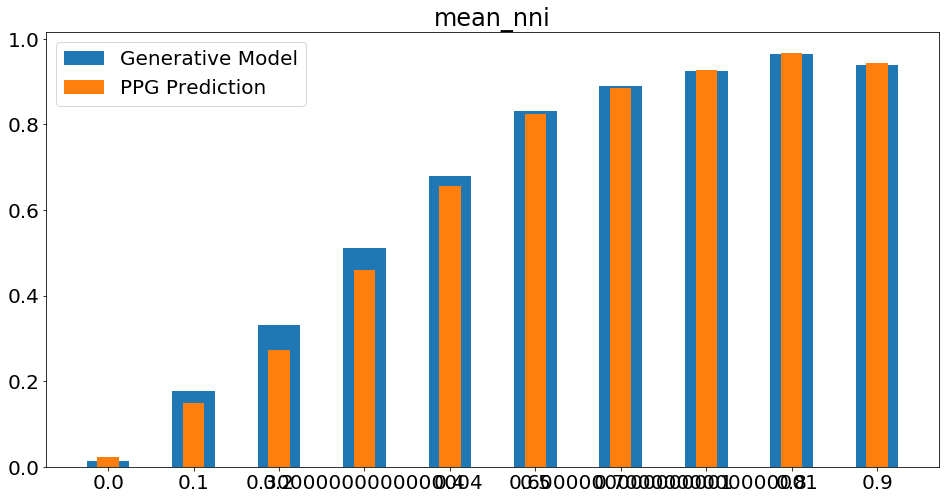

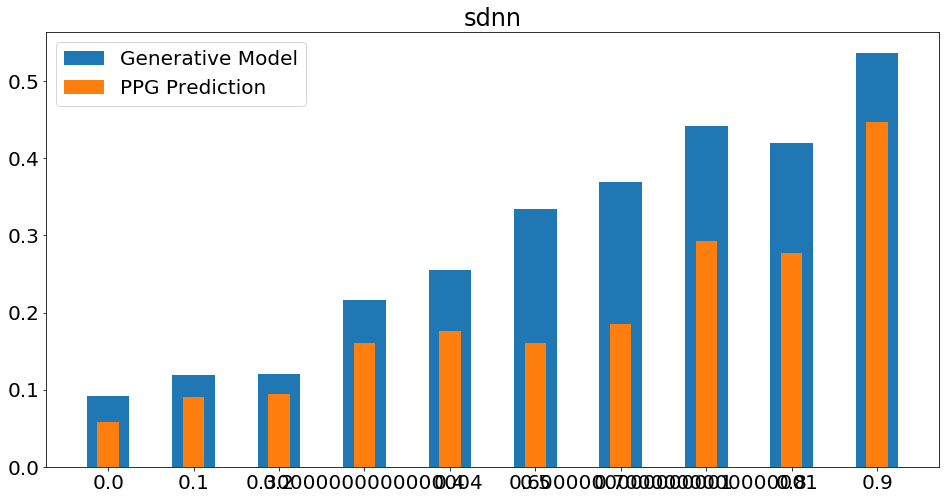

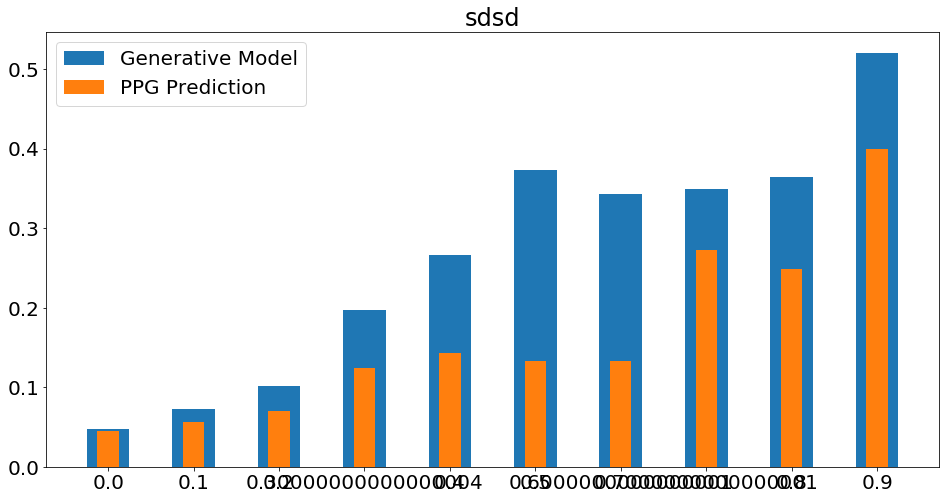

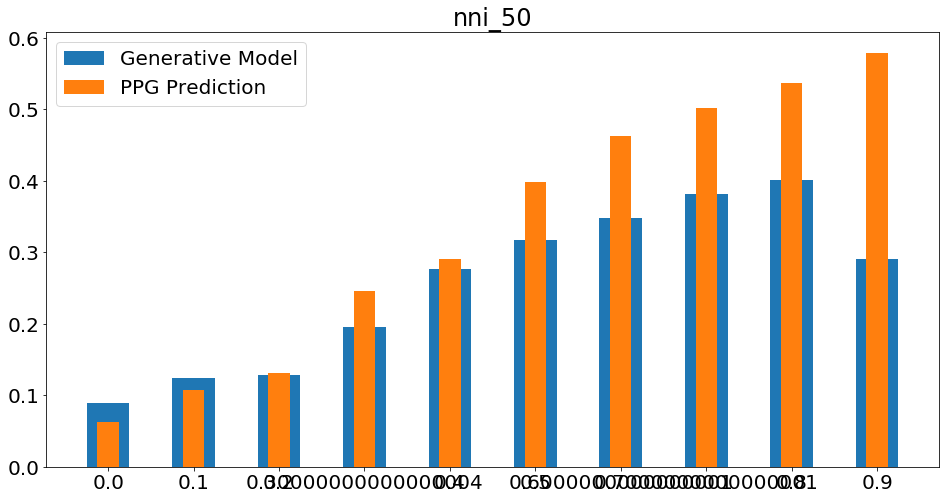

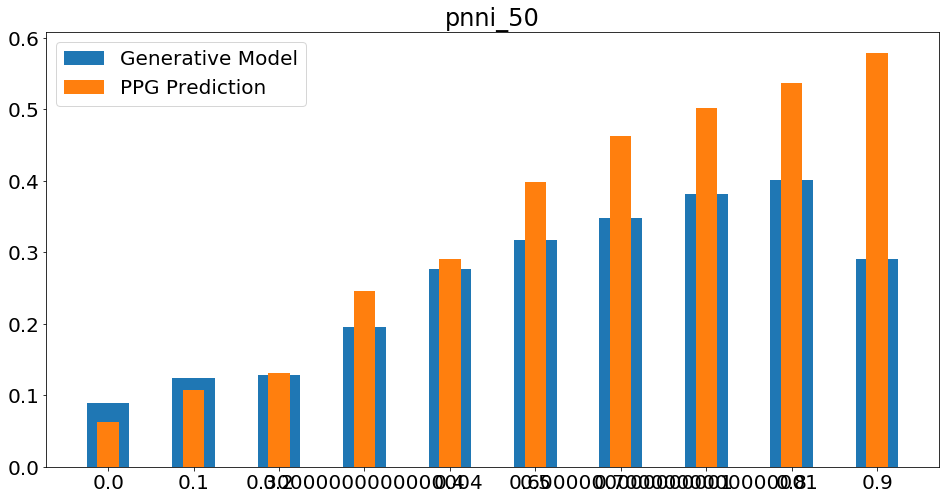

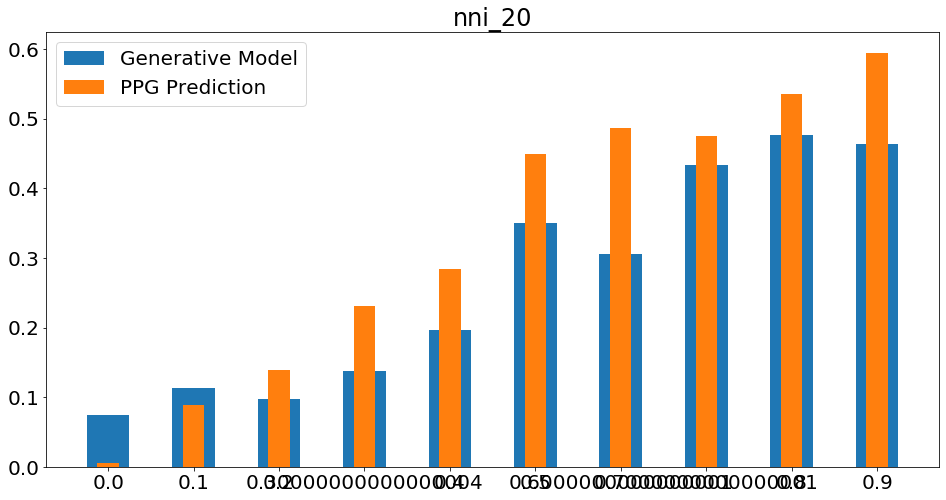

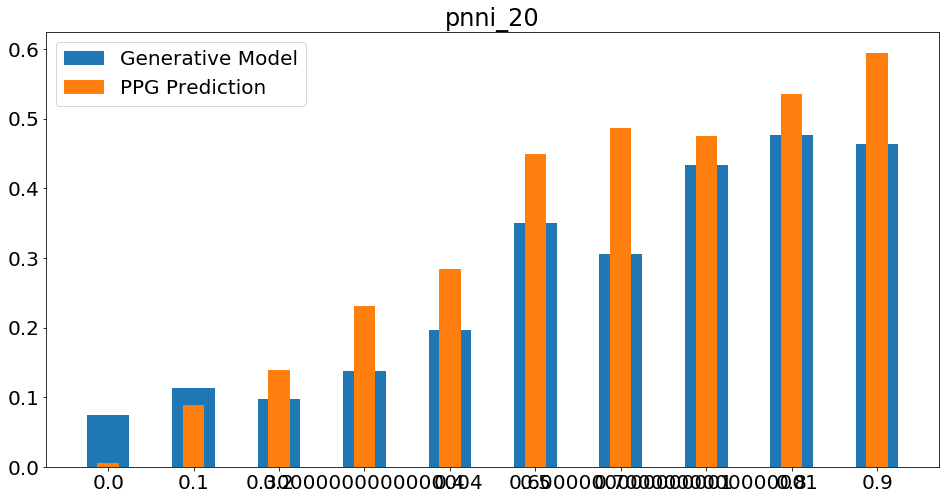

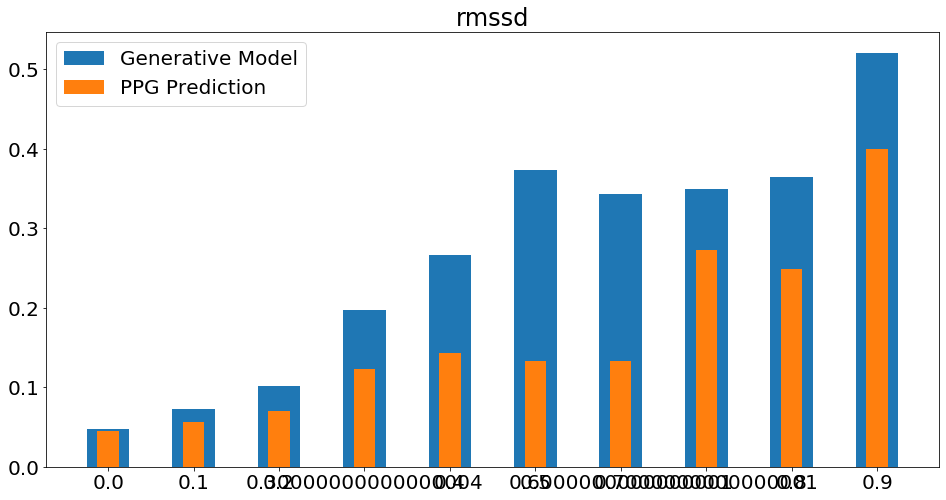

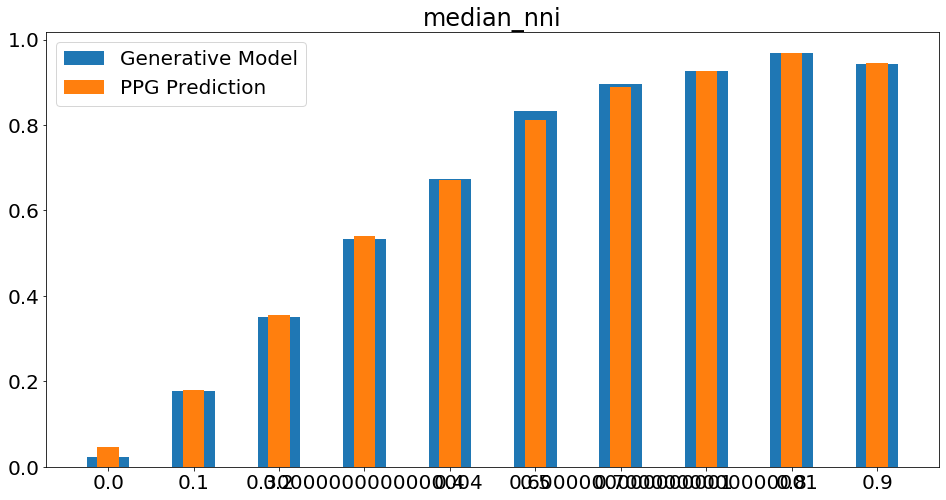

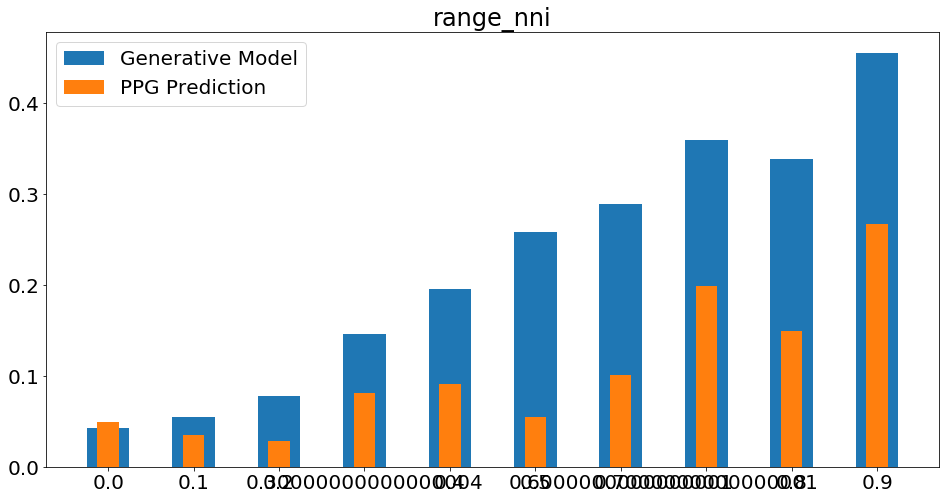

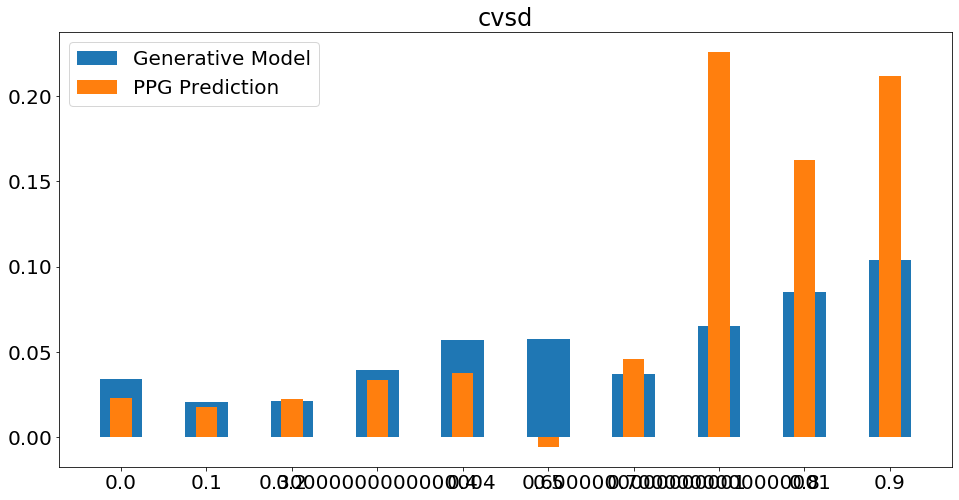

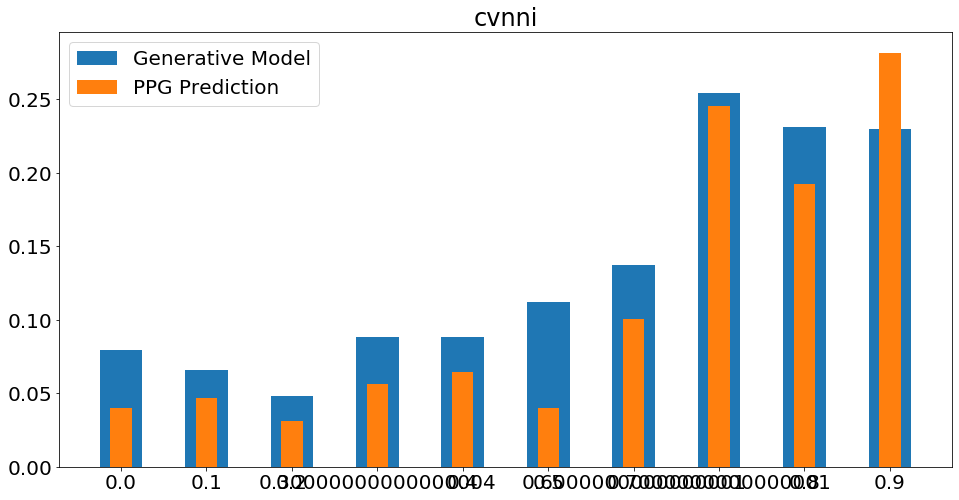

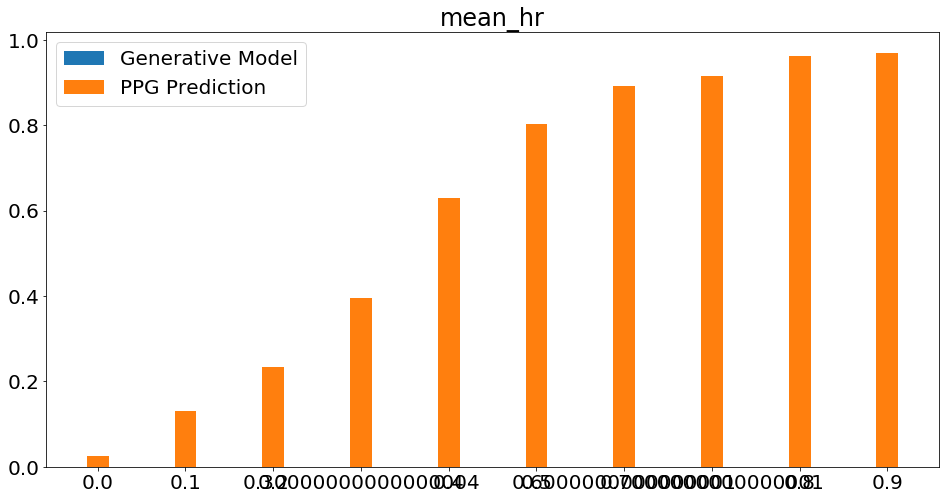

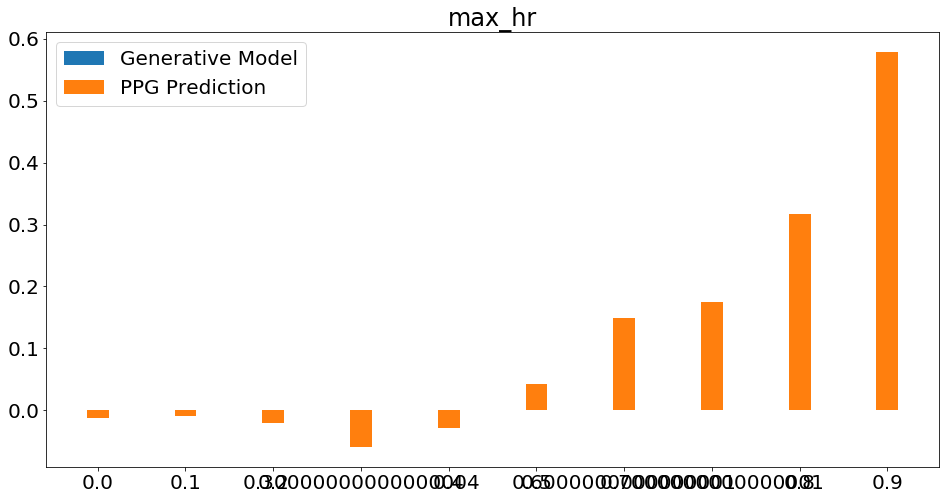

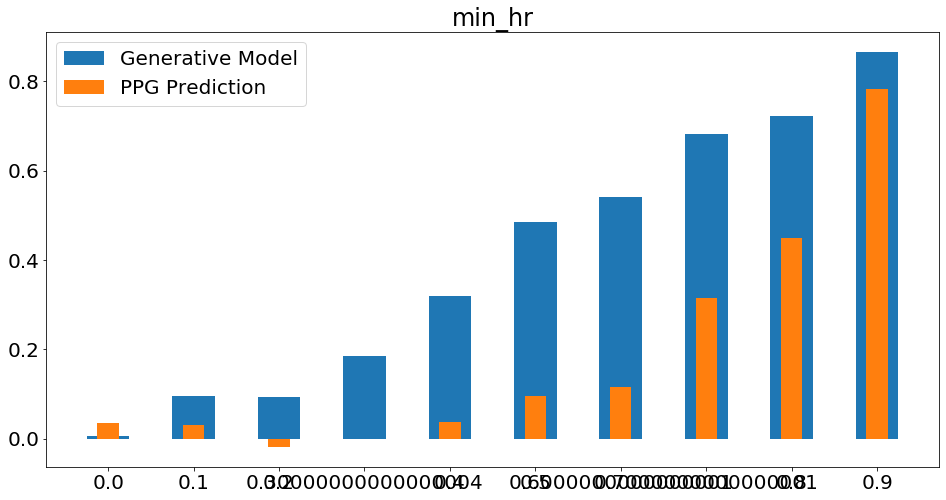

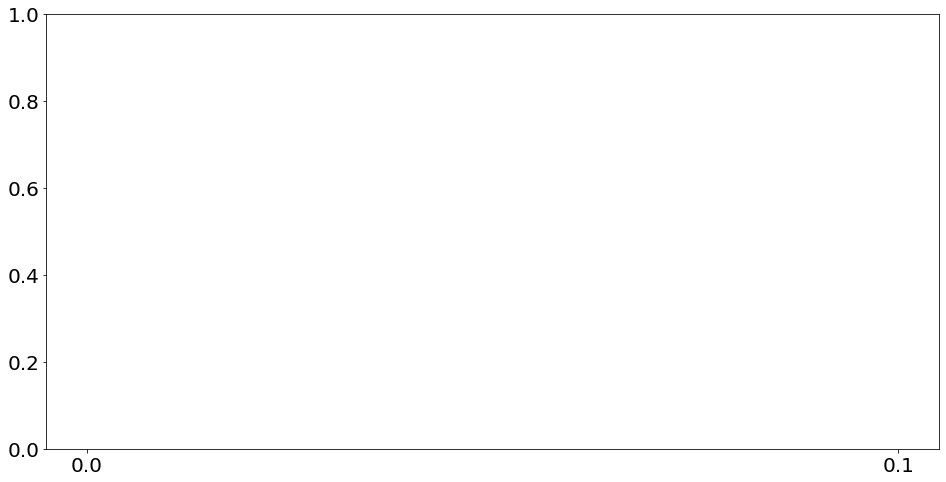

In [59]:
from scipy.stats import pearsonr
feature_col = ['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd',
 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr', 'std_hr']

def get_pearson(x,y):
    index = ~np.isnan(x)
    x,y = x[index],y[index]
    index = ~np.isnan(y)
    x,y = x[index],y[index]
    return pearsonr(x,y)[0]

for j in range(len(feature_col)):
    x = []
    y = []
    y1 = []
    for i in np.linspace(0,.9,10):
        index = np.where((q>=i)&(q<=i+.10))[0]
#         print(len(index))
        if len(index)<10:
            continue
        x.append(str(i))
#         print(pearsonr(ecgs[index,j],preds[index,j])[0])
        try:
            y.append(get_pearson(ecgs[index,j],preds[index,j]))
            y1.append(get_pearson(ecgs[index,j],fpreds[index,j]))
        except:
            continue
    try:
        plt.figure(figsize=(16,8))
        plt.bar(x,y,.5,label='Generative Model')
        plt.bar(x,y1,.25,label='PPG Prediction')
        plt.title(feature_col[j])
        plt.legend()
        plt.show()
    except Exception as e:
        continue
        

In [ ]:
from hrvanalysis import get_time_domain_features
x = []
y = []
z = []
q = []
s = 'rmssd'
for i in range(ecg_test.shape[0]):
    qual_min = quals_test[i].reshape(-1)
    qual_min = qual_min[qual_min>-1]
    ecg_min = ecg_test[i].reshape(-1)
    ecg_min = ecg_min[ecg_min>0]
    ecg_min= ecg_min[~np.isnan(ecg_min)]
    y_pred_min = y_pred[i].reshape(-1)
    y_pred_min = y_pred_min[~np.isnan(y_pred_min)]
    y_test_min = y_test[i].reshape(-1)
    y_test_min = y_test_min[y_test_min>0]
    y_test_min = y_test_min[~np.isnan(y_test_min)]
    if len(ecg_min)<10 or len(y_pred_min)<5 or len(y_test_min)<5:
        continue
    x.append(get_time_domain_features(y_pred_min)[s])
    y.append(get_time_domain_features(ecg_min)[s])
    z.append(get_time_domain_features(y_test_min)[s])
    q.append(np.median(qual_min))
    if np.isinf(x[-1]) or np.isinf(y[-1]) or np.isinf(z[-1]) or np.isinf(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
    elif np.isnan(x[-1]) or np.isnan(y[-1]) or np.isnan(z[-1]) or np.isnan(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
#     print(np.std(ecg_min),np.std(y_test_min),np.std(y_pred_min),np.median(qual_min))
    
    

In [ ]:
from scipy.stats import pearsonr,spearmanr
q,x,y,z = np.array(q),np.array(x),np.array(y),np.array(z)
for i in np.linspace(0,.9,10):
    index = np.where((q>=i)&(q<=i+.1))[0]
    if len(index)<2:
        continue
    print(pearsonr(x[index],y[index]),pearsonr(y[index],z[index]),i,i+.1,len(index))

In [ ]:
# plt.hist(y.reshape(-1),50)
plt.hist(y_pred.reshape(-1),50)
plt.hist(ecg_test.reshape(-1),50)

In [ ]:
np.std(y[0].reshape(1,-1,1),axis=1)

In [ ]:
plt.plot(y_pred1[1].reshape(-1),means_test.reshape(-1),'*')

In [ ]:
from scipy.stats import pearsonr
pearsonr(y_pred1[1].reshape(-1),means_test.reshape(-1))

In [ ]:
import keras

In [ ]:
keras.__version__

In [ ]:
y_pred.reshape(-1).shape

In [ ]:
t = y_pred.reshape(-1)

In [ ]:
t[np.isfinite(t)].shape

In [ ]:
plt.hist(quals_test.reshape(-1))

In [ ]:
!pip install --user tensorflow-probability